In [1]:
import sys
import numpy
import warnings
from sklearn.decomposition import FastICA
warnings.filterwarnings("ignore")
sys.path.append("../")
from lib.metadata import MetadataListSiena
from lib.signals import EegProcessorSiena
from lib.spectral import FourierAnalysis
from lib.filters import FilterBank
from lib.bss import IWasobi
from lib.visuals import plot_eeg_windows, plot_eeg_spectrum

/var/tmp/venv-project-1/lib/python3.11/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### * Scales the EEG signal
### * Select a subset of the channels

Extracting EDF parameters from /mnt/c/Users/tobit/Downloads/eeg_datasets/siena/PN00/PN00-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2025-02-17 14:30:48,359 - root - INFO - Recording contains channels = ['EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7', 'EEG T3', 'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG Fp2', 'EEG F4', 'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2', 'EEG Cp6', 'EEG F10', 'EKG EKG', 'SPO2', 'HR', '1', '2', 'MK']


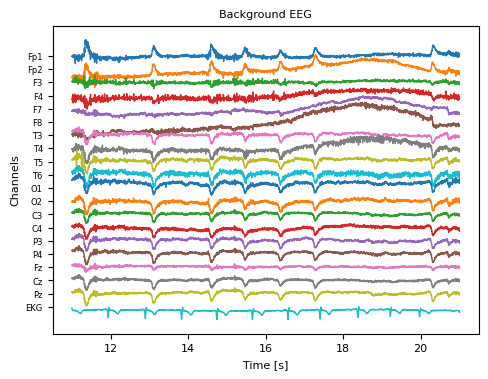

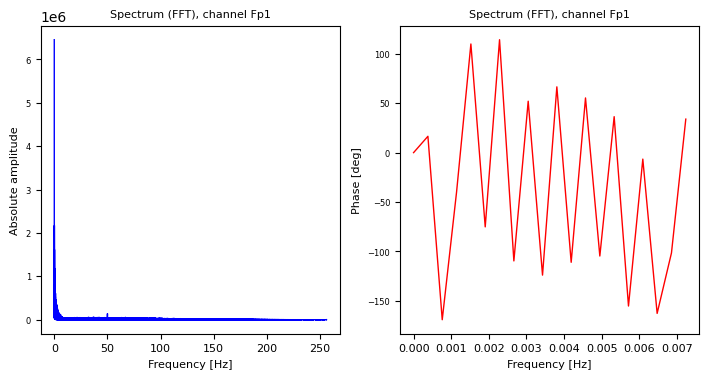

In [2]:
PATIENT = "PN00"
FILENAME = "PN00-1.edf"
PERIOD = [11, 21]

###########################################################
metadata = MetadataListSiena()
current_metadata = metadata.get(PATIENT, FILENAME)

###########################################################
processor = EegProcessorSiena(current_metadata["full_file"])
processor.select_channels()
processor.scale(ekg_reference=True)

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "Fp1")

###### DROP EKG CHANNELS FOR THE REST OF THE PROCESS ######


### * Resample the EEG to 256Hz

2025-02-17 14:30:57,443 - root - INFO - Dowsampling factor is = 2


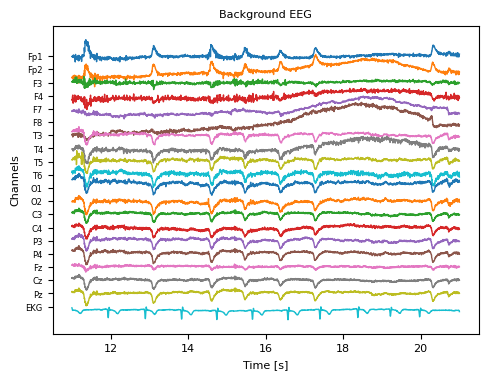

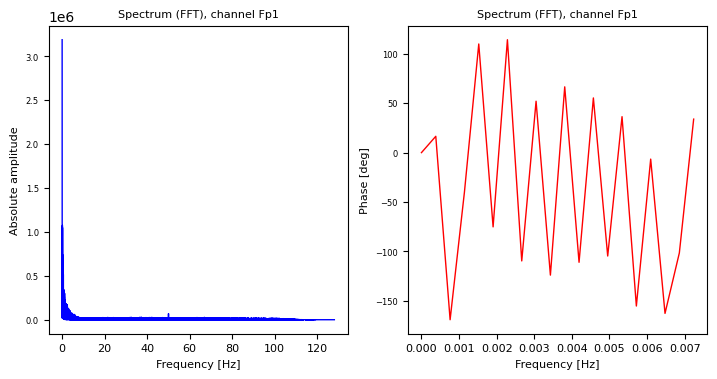

In [3]:
###########################################################
processor.resample()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "Fp1")

### * Remove the drift noise, high frequency oscillations, power line noise

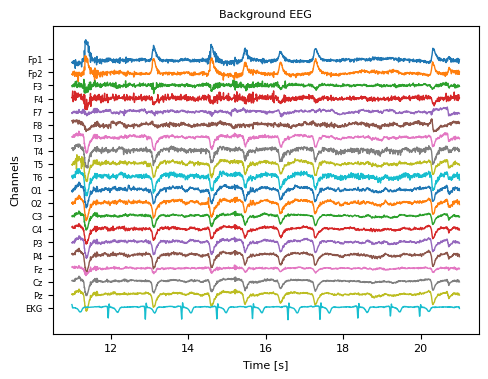

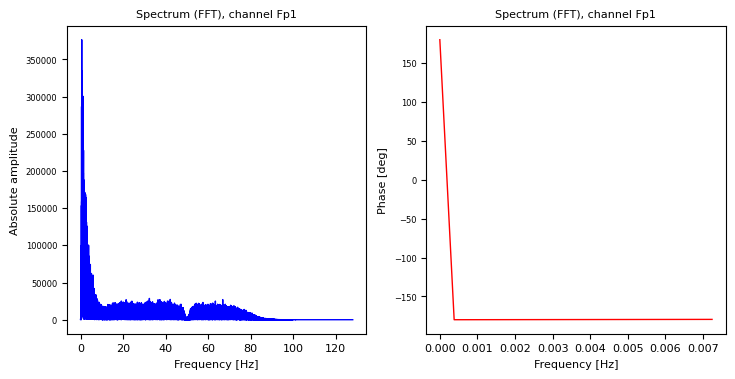

In [4]:
###########################################################
processor.filter_bank = FilterBank(0)
processor.remove_drift()
processor.remove_hfo()
processor.remove_power_noise()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "Fp1")

### * Separated sources using iWASOBI

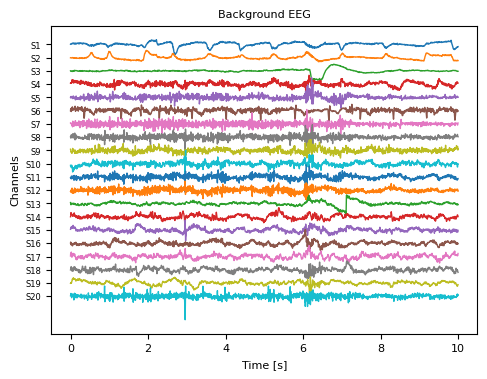

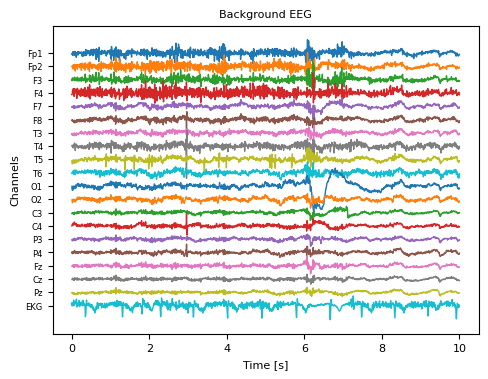

In [5]:
iwasobi = IWasobi()
eeg_sources = iwasobi.fit_transform(processor._data[:, :2560])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eeg_sources[0, :] = 0
eeg_sources[1, :] = 0
clean_eeg = iwasobi.inverse_transform(eeg_sources)

plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Separated sources using fastica

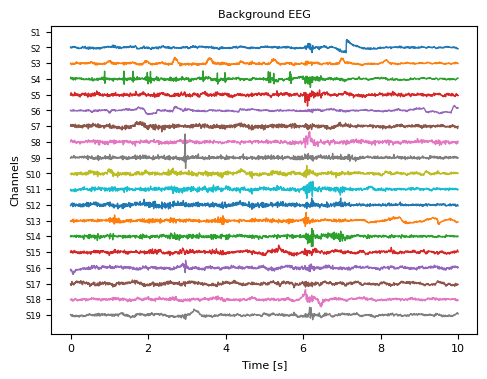

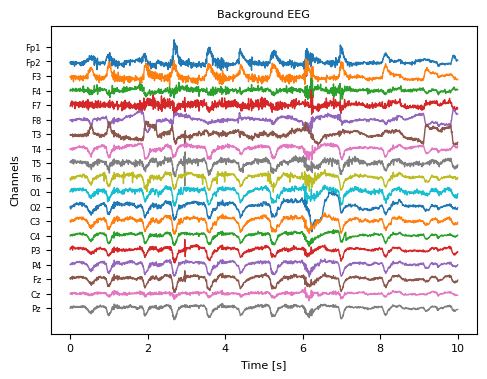

In [24]:
fastica = FastICA()
eeg_sources = fastica.fit_transform(numpy.transpose(processor._data[:, :2560]))

###########################################################
plot_eeg_windows(numpy.transpose(eeg_sources), current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[1] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eeg_sources[16, :] = 0
clean_eeg = fastica.inverse_transform(eeg_sources)
plot_eeg_windows(numpy.transpose(clean_eeg), current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])